## Trip advisor - предсказание рэйтинга

#### импорт библиотек

In [4]:
import numpy as np 
import pandas as pd 
pd.options.display.max_colwidth = 300
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import string
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import re
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn import metrics
import pandas_profiling

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.berezovaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\a.berezovaya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\a.berezovaya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a.berezovaya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

#### Импорт данных

In [6]:
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

Данные по населению из открытого датасета: 
https://public.opendatasoft.com/explore/dataset/worldcitiespop/table/?disjunctive.country&sort=population
Иногда названия городов повторяются, так что оставила более крупные

In [7]:
cities = pd.read_csv(DATA_DIR+'/cities.csv')
cities = cities.sort_values(by='Population', ascending=False)
cities = cities.drop_duplicates(subset=['City'], keep='first')

In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

### Предварительный анализ данных

In [9]:
#У меня падал pandas profiling на ценах, поэтому привожу в числовые значения
price_dict = {'$': 1, '$$ - $$$': 2,'$$$$' : 3}
data['Price Range'] = data['Price Range'].replace(price_dict)

In [10]:
#profile = pandas_profiling.ProfileReport(df_describe)

In [11]:
#profile.to_notebook_iframe()

### 1. Restaurant_id

In [12]:
data['Restaurant_id'].isna().sum()

0

***Резюме - Restaurant_id:*** исхожу из предположения что это просто индекс.
https://www.kaggle.com/damienbeneschi/krakow-ta-restaurans-data-raw

### 2. Cuisine Style

In [13]:
# Сохраню информацию где были пустые значения
data['NAN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('float64') 

# Заполню пропуски
data['Cuisine Style'].fillna("['Other']", inplace=True)

# Сохраню значения в виде списка
data['Cuisine Style list'] = data['Cuisine Style'].fillna('[]').str.strip("'[] ").str.split("', '").tolist()

# И в виде количества в списке
data['Cuisine count'] = data['Cuisine Style list'].str.len()

# Кодирую кухню
label_encoder = LabelEncoder()
data['Cuisine Style'] = pd.Series(label_encoder.fit_transform(data['Cuisine Style']))

Text(0.5, 1.0, 'Оценки по кухне')

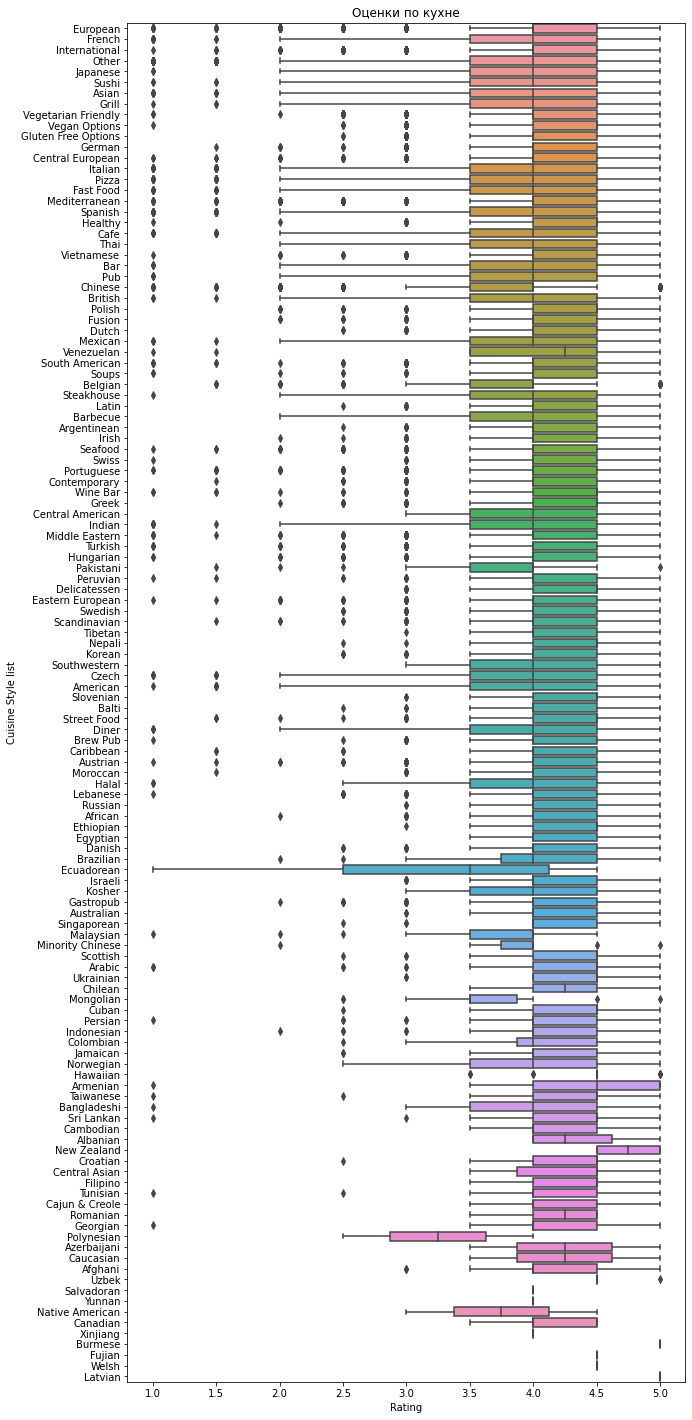

In [14]:
# Смотрим зависимость оценки от кухни
plt.figure(figsize = (10,25))
sns.boxplot(orient = 'h' ,x = 'Rating', y='Cuisine Style list', data = data[data['sample'] == 1][['Cuisine Style list','Rating']]\
                                                                        .explode('Cuisine Style list'))
plt.title('Оценки по кухне')

In [15]:
#Редкие кухни выносим как отдельную колонку
rare_cuisin = data['Cuisine Style list'].explode().value_counts().nsmallest(16).index
data['unique_Cuisine_Style'] = data['Cuisine Style list']\
                                        .apply(lambda x: 1 if len(set(x) & set(rare_cuisin))>0  else 0).astype('float64')

# Создаем списки с самыми высоко и низко оцененными кухнями
dt = data[data['sample'] == 1][['Cuisine Style list','Rating','Restaurant_id']].explode('Cuisine Style list').copy()
dt = dt.groupby(by = 'Cuisine Style list').agg({'Restaurant_id':'size', 'Rating':'mean'}) \
       .rename(columns={'Restaurant_id':'nunique','Rating':'median'}) \
       .reset_index()

liked_cusisine = dt[(dt['median'] >= 4.3)&(dt['nunique'] >3)]['Cuisine Style list'].to_list()
disliked_cusisine = dt[(dt['median'] <= 3.8)&(dt['nunique'] >3)]['Cuisine Style list'].to_list()

# Добавляем колонки с любимой и не любимой кухней
data['Liked_Cuisine_Style'] = data['Cuisine Style list']\
                                        .apply(lambda x: 1 if len(set(x) & set(liked_cusisine))>0  else 0).astype('float64')

data['Not_liked_Cuisine_Style'] = data['Cuisine Style list']\
                                        .apply(lambda x: 1 if len(set(x) & set(disliked_cusisine))>0  else 0).astype('float64')

Text(0.5, 1.0, 'Кореляция получившихся колонок')

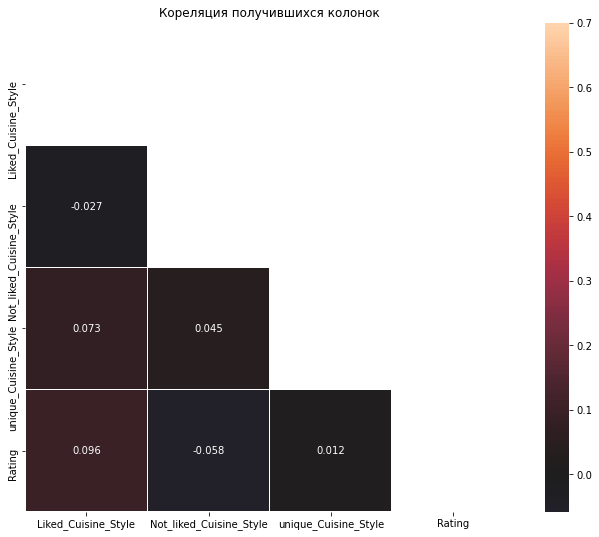

In [16]:
corr = data[data['sample'] == 1][['Liked_Cuisine_Style','Not_liked_Cuisine_Style','unique_Cuisine_Style','Rating']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=0.7, center=0,
            square=True, linewidths=.5 ,annot =True)

plt.title('Кореляция получившихся колонок')

***Резюме - Cuisine Style:*** Есть пропуски (поле NAN_Cuisine Style), есть очень редкие кухни (unique_Cuisine_Style) и фавориты. Одному ресторану соответствует несколько типов (Cuisine count). Не уверенна если разбить на колонки или оставить просто закодировать

### 3. Price Range

In [17]:
# Сохраню информацию где были пустые значения
data['NaN_Price Range'] = pd.isna(data['Price Range']).astype('float64') 

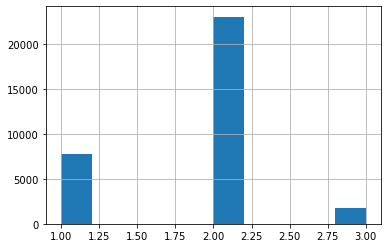

In [18]:
# Большинство ресторанов имеют среднюю ценовую категорию
data['Price Range'].hist()

In [19]:
# Заполню пропуски 
data['Price Range'] = data['Price Range'].fillna(2)

***Резюме - Price Range:*** Есть пропуски (NaN_Price Range). Оставляю кодовую версию (Price_Range)

### 4. Number of Reviews

In [20]:
# Сохраню информацию где были пустые значения
data['NAN_Number of Reviews'] = pd.isna(data['Number of Reviews']).astype('float64')

# Выбросы?

# Заполняю 1, так как кто-то поставил оценку
data['Number of Reviews'].fillna(1, inplace=True)

***Резюме - Number of Reviews:*** Есть пропуски (NAN_Number of Reviews) и пока не ясно чем их лучше заполнить. Имеет смысл поискать распределение или корреляцию

### 5. Reviews

#### Дата

In [21]:
# Есть пропуски в виде [[], []] и просто NaN
data['Reviews'] = data['Reviews'].fillna('[[], []]')
data['empty_Reviews'] = (data['Reviews']=='[[], []]').astype('float64')

In [22]:
# Есть даты отзывов после текста 
data['date_of_Review'] = data['Reviews'].str.findall('\d+/\d+/\d{4}')

# Записываю количество дат
data['len_date'] = data['date_of_Review'].str.len()

# Иногда даты есть в тексте и нужно их удалить
data['len_date'].date_of_Review = data[data['len_date']==3].date_of_Review.apply(lambda x: x.pop(0))

# Помечаю где только одна дата
data['one_Review'] = (data['len_date']==1).astype('float64')

In [23]:
# Создаю столбцы с разницей во времени между отзывами и как давно они были написаны
def time_to_now(row):
    if row['date_of_Review'] == []:
        return None
    return pd.datetime.now() - pd.to_datetime(row['date_of_Review']).max()

def time_between_Reviews(row):
    if row['date_of_Review'] == []:
        return None
    return pd.to_datetime(row['date_of_Review']).max() - pd.to_datetime(row['date_of_Review']).min()

data['day_to_now'] = data.apply(time_to_now, axis = 1).dt.days
data['day_between_Reviews'] = data[data['len_date']==2].apply(time_between_Reviews, axis = 1).dt.days

<ipython-input-23-44d436ce72dd>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.now() - pd.to_datetime(row['date_of_Review']).max()


Text(0.5, 1.0, 'Кореляция получившихся колонок')

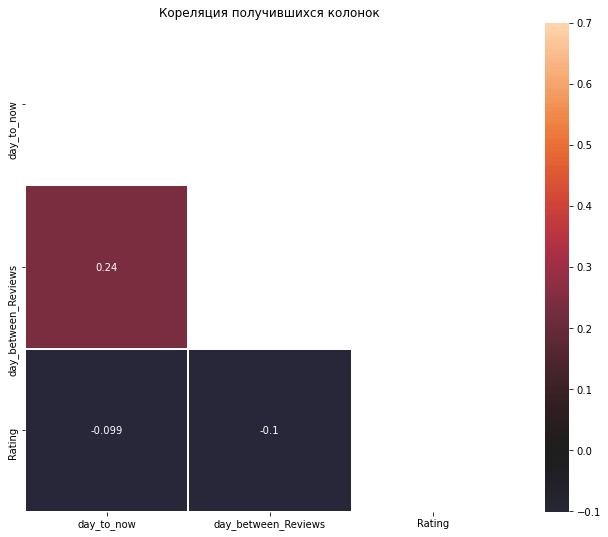

In [24]:
corr = data[data['sample'] == 1][['day_to_now','day_between_Reviews','Rating']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=0.7, center=0,
            square=True, linewidths=.5 ,annot =True)

plt.title('Кореляция получившихся колонок')

***Резюме - Reviews даты:*** Есть пустые (empty_Reviews). Добавила колонки с разницей во времени между отзывами (day_between_Reviews) и давностью последнего отзыва (day_to_now)

#### Текст

In [25]:
# функции для очистки и маркировки
def clean_text(text):
    """
    Принимает текст, очищает от пунктуации и шума. Приводит в нижний регистр.
    """
    text = text.lower()
    
    # убираю пунктуацию
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # убираю числа
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # убираю шум
    stop = stopwords.words('english')
    newStopWords = ['restaurant','food','pizza','cafe','dinner','supper','breakfast','bar','lunch','place','service']
    stop.extend(newStopWords)
    text = [x for x in text if x not in stop]
    
    # убираю лишние пропуски и артикли
    text = [t for t in text if len(t) > 1]

    #собираю обратно в строку
    text = " ".join(text)
    
    return(text)

# очищаем
data["review_clean"] = data['Reviews'].apply(lambda x: clean_text(x))

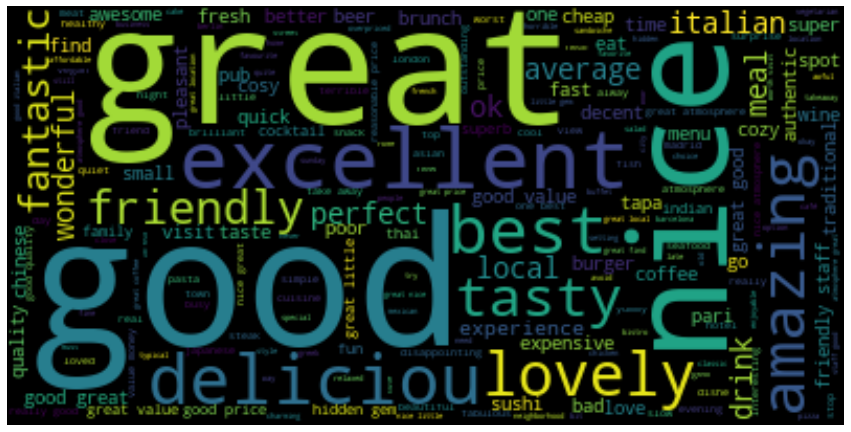

In [26]:
wordcloud = WordCloud().generate(data['review_clean'].str.cat(sep=','))

plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
# разбиваем на позитивные/негативные/нейтральные
sid = SentimentIntensityAnalyzer()
data["sentiments"] = data["review_clean"].apply(lambda x: sid.polarity_scores(x))
data = pd.concat([data.drop(['sentiments'], axis=1), data['sentiments'].apply(pd.Series)], axis=1)

# Количество символов
data["nb_chars"] = data["review_clean"].apply(lambda x: len(x))

# Количество слов
data["nb_words"] = data["review_clean"].apply(lambda x: len(x.split(" ")))

# Выбросы?

Text(0.5, 1.0, 'Кореляция получившихся колонок')

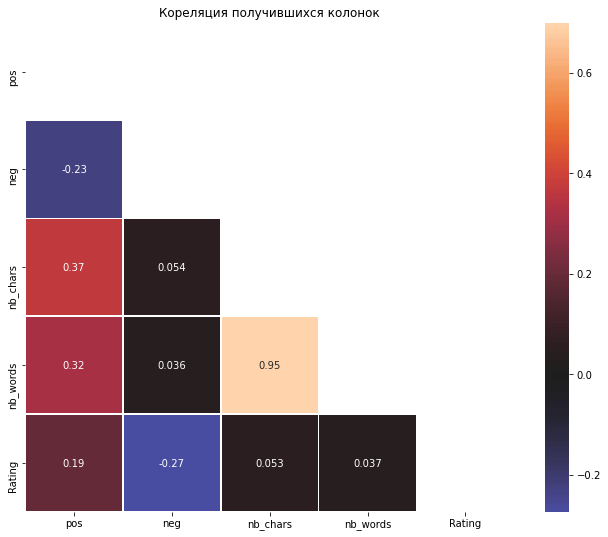

In [28]:
corr = data[data['sample'] == 1][['pos','neg','nb_chars','nb_words','Rating']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=0.7, center=0,
            square=True, linewidths=.5 ,annot =True)

plt.title('Кореляция получившихся колонок')

***Резюме - Reviews текст:*** Сохраняю эмоциональный окрас (pos, neg), количество символов (nb_chars) и слов (nb_words)

### 6. ID_TA

In [29]:
data['ID_TA'].isna().sum()

0

***Резюме - ID_TA:*** id, пропусков нет

### 7. URL_TA

In [30]:
data['URL_TA'].isna().sum()

0

***Резюме - URL_TA:*** пропусков нет, можно использовать для парсинга

### 8. City

In [31]:
# Привожу к нижнему регистру и дополняю населением 
data['City'] = data['City'].str.lower()
data = data.merge(cities[['City','Population','Country']], on = 'City', how = 'left')

# Отмечаю столицы
list_Of_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
data['Capital_City'] = data['City'].apply(lambda x: 0.0 if x in list_Of_NotCapitalCity else 1.0)

# Заполняю пропуски
data['Population'] = data['Population'].fillna(data['Population'].mean())
data['Country'] = data['Country'].fillna('not found')

# Кодирую город и страну
label_encoder = LabelEncoder()
data['Country_num'] = pd.Series(label_encoder.fit_transform(data['Country']))
data['City_num'] = pd.Series(label_encoder.fit_transform(data['City']))

***Резюме - City:*** пропусков нет, признак категориальный 

Добавлены признаки:
    - Страна (Country, Country_num)
    - Столица (Capital_City)
    - Население (Population)

### 9. Ranking

In [32]:
# Нормированный Ranking по населению
mean_Ranking_on_City = data.groupby(['City'])['Ranking'].mean()
data['mean_Ranking_on_City'] = data['City'].apply(lambda x: mean_Ranking_on_City[x])
data['norm_Ranking_on_Popul_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['Population']

# Нормированный Ranking по ресторанам
count_Restorant_in_City = data['City'].value_counts(ascending=False)
data['count_Restorant_in_City'] = data['City'].apply(lambda x: count_Restorant_in_City[x])
data['norm_Ranking_on_Rest_in_City'] = (data['Ranking'] - data['mean_Ranking_on_City']) / data['count_Restorant_in_City']

# Население на ресторан
data['norm_Population_on_Rest'] = data['Population']/data['count_Restorant_in_City']

Text(0.5, 1.0, 'Кореляция получившихся колонок')

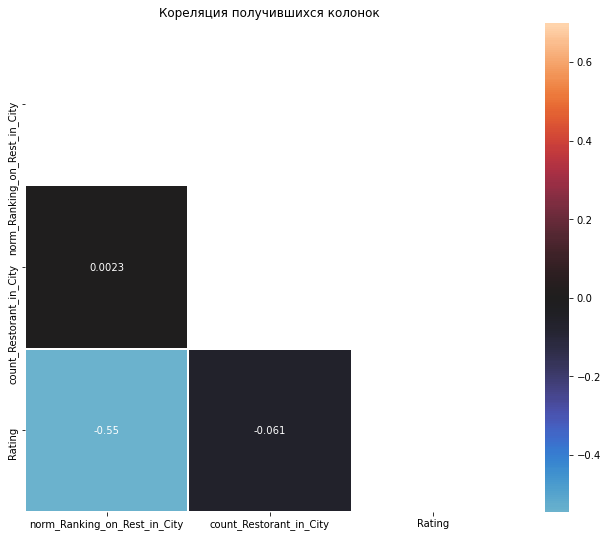

In [33]:
corr = data[data['sample'] == 1][['norm_Ranking_on_Rest_in_City','count_Restorant_in_City','Rating']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=0.7, center=0,
            square=True, linewidths=.5 ,annot =True)

plt.title('Кореляция получившихся колонок')

***Резюме - Ranking:*** Пропусков нет. 

Добавлены признаки:
    - Нормированный Ranking на население города (norm_Ranking_on_Popul_in_City)
    - Нормированный Ranking на ресторан, город (norm_Ranking_on_Rest_in_City)
    - Плотность населения на ресторан (norm_Population_on_Rest)

### Смотрим что получилось

In [34]:
data.head(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Population,Country,Capital_City,Country_num,City_num,mean_Ranking_on_City,norm_Ranking_on_Popul_in_City,count_Restorant_in_City,norm_Ranking_on_Rest_in_City,norm_Population_on_Rest
0,id_0,paris,1778,12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html,d10746918,0,...,2110694.0,fr,1.0,8,24,6938.557138,0.002854,6108,0.986320,345.562213
1,id_1,helsinki,4076,106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html,d6674944,0,...,558457.0,fi,1.0,7,12,564.231579,-0.000821,475,-0.964698,1175.698947


### Удаляем нечисловые показатели

In [35]:
data.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'date_of_Review','review_clean', 'len_date', 'Сountry', 'Population', 'mean_Ranking_on_City', 'count_Restorant_in_City', 'max_Ranking_on_City', 'Country', 'Cuisine Style list'], axis=1, inplace=True, errors='ignore')

In [36]:
data.dtypes

Ranking                          float64
Number of Reviews                float64
sample                             int64
Rating                           float64
NAN_Cuisine Style                float64
Cuisine count                      int64
unique_Cuisine_Style             float64
Liked_Cuisine_Style              float64
Not_liked_Cuisine_Style          float64
NaN_Price Range                  float64
NAN_Number of Reviews            float64
empty_Reviews                    float64
one_Review                       float64
day_to_now                       float64
day_between_Reviews              float64
neg                              float64
neu                              float64
pos                              float64
compound                         float64
nb_chars                           int64
nb_words                           int64
Capital_City                     float64
Country_num                        int32
City_num                           int32
norm_Ranking_on_

### Стандартизируем и заполняем нулями пропуски по всем переменным

In [37]:
# функция для стандартизации
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(data[[d_col]])
    return scaler.transform(data[[d_col]])

In [38]:
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(data.columns):
    if i not in ['Rating','sample']:
        data[i] = StandardScaler_column(i)
        if len(data[data[i].isna()]) < len(data):
            data[i] = data[i].fillna(0)

In [39]:
# проверяем заполнение
display(data.describe().head(1))

,Ranking,Number of Reviews,sample,Rating,NAN_Cuisine Style,Cuisine count,unique_Cuisine_Style,Liked_Cuisine_Style,Not_liked_Cuisine_Style,NaN_Price Range,...,pos,compound,nb_chars,nb_words,Capital_City,Country_num,City_num,norm_Ranking_on_Popul_in_City,norm_Ranking_on_Rest_in_City,norm_Population_on_Rest
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0


### Разбиваем датасет на тренировочный и тестовый

In [40]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [41]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [42]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 26), (40000, 26), (40000, 25), (32000, 25), (8000, 25))

### Обучаем модель, генерируем результат и сравниваем с тестом

In [44]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [45]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [46]:
def classic_round(d_num):
    return int(d_num + (0.5 if d_num > 0 else -0.5))

def my_round(d_pred):
    result = classic_round(d_pred*2)/2
    if result <=5:
            return result
    else:
        return 5

my_vec_round = np.vectorize(my_round)

In [47]:
y_pred = my_vec_round(y_pred)

In [48]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', MAE)

MAE: 0.17025


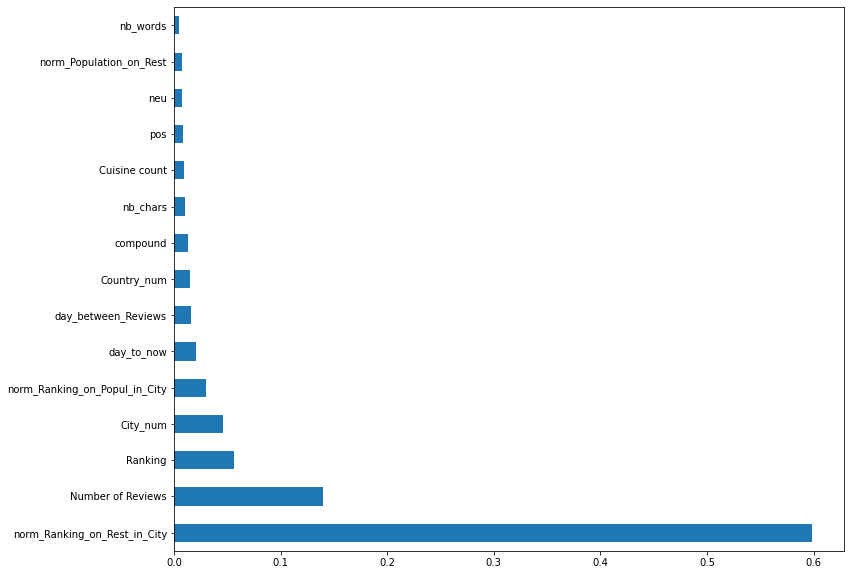

In [49]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [50]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,NAN_Cuisine Style,Cuisine count,unique_Cuisine_Style,Liked_Cuisine_Style,Not_liked_Cuisine_Style,NaN_Price Range,NAN_Number of Reviews,...,pos,compound,nb_chars,nb_words,Capital_City,Country_num,City_num,norm_Ranking_on_Popul_in_City,norm_Ranking_on_Rest_in_City,norm_Population_on_Rest
9966,-0.732267,-0.285063,0.0,-0.549313,0.205415,-0.034662,-0.203858,-0.175318,-0.729321,-0.261488,...,0.074407,-0.028716,0.397059,-0.051619,0.0,-1.823830,1.387278,-0.416651,-0.785180,0.143521
5352,-0.195788,-0.393400,0.0,-0.549313,0.753658,-0.034662,-0.203858,-0.175318,-0.729321,-0.261488,...,0.600262,1.012436,0.994260,0.856531,0.0,-0.984187,-1.492240,-0.080245,-0.174693,0.330438
1587,-0.878210,3.663994,0.0,-0.549313,2.398385,-0.034662,-0.203858,-0.175318,-0.729321,-0.261488,...,0.107461,0.427943,0.038738,0.402456,0.0,-0.564366,-1.607421,-1.907346,-1.528785,-0.548578
4790,0.416635,-0.110326,0.0,-0.549313,-0.342827,-0.034662,-0.203858,-0.175318,-0.729321,-0.261488,...,0.864693,1.023987,0.815100,0.856531,0.0,0.065366,0.005109,-0.345273,-0.617278,0.081720
4412,2.027422,-0.365442,0.0,-0.549313,-0.891069,-0.034662,-0.203858,-0.175318,1.371138,-0.261488,...,0.483072,0.834803,1.053980,0.856531,0.0,-0.144545,0.926555,1.731630,1.036894,-0.678137
5550,-0.680105,-0.299042,0.0,-0.549313,0.205415,-0.034662,4.905370,-0.175318,-0.729321,-0.261488,...,0.861688,1.234476,1.710902,1.310605,0.0,-1.823830,1.387278,-0.310323,-0.584804,0.143521
1494,-0.789833,-0.382915,0.0,-0.549313,0.205415,-0.034662,-0.203858,-0.175318,-0.729321,-0.261488,...,0.299773,0.796556,0.695660,1.310605,0.0,2.584295,-1.377060,0.570425,1.102209,0.174042
2312,-0.729294,-0.309526,0.0,-0.549313,-0.891069,-0.034662,-0.203858,-0.175318,-0.729321,-0.261488,...,-0.328248,-0.183503,0.337339,0.856531,0.0,-0.984187,0.581013,-0.280504,-0.528995,0.144395
8096,-0.678213,0.116833,0.0,-0.549313,0.205415,-0.034662,-0.203858,-0.175318,-0.729321,-0.261488,...,1.348480,1.111776,-0.080702,-0.051619,0.0,-1.613920,-1.261879,-0.328261,-0.441124,-0.202014
7138,0.048262,-0.316515,0.0,-0.549313,-0.342827,-0.034662,-0.203858,-0.175318,-0.729321,-0.261488,...,0.401940,0.019799,-0.737624,-0.505694,0.0,-0.564366,-1.607421,-0.020053,-0.016073,-0.548578


In [51]:
test_data = test_data.drop(['Rating'], axis=1)

In [52]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [59]:
predict_submission = model.predict(test_data)
predict_submission=my_vec_round(predict_submission)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [61]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
